# Test Pipeline Notebook

This notebook is used to test the training pipeline and deployment manually locally before executing it in the pipeline.

## Global vars and libraries

Make sure you use sagemaker version >= 2.15.0 and tensorflow >= 2.0

In [2]:
%%sh
pip install --upgrade sagemaker==2.15.0

Processing /home/ec2-user/.cache/pip/wheels/b5/af/5b/dd429efe1e5c3e5e54340ec49407c59ffe0a6bbdfde21ceb4b/sagemaker-2.15.0-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-0.1.5-py2.py3-none-any.whl (6.2 kB)
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 0.1.4
    Uninstalling smdebug-rulesconfig-0.1.4:
      Successfully uninstalled smdebug-rulesconfig-0.1.4
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 1.72.1
    Uninstalling sagemaker-1.72.1:
      Successfully uninstalled sagemaker-1.72.1


You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [1]:
# import libraries
import os
import json
import yaml
import tarfile
import datetime
from PIL import Image
import numpy as np
import csv
import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tensorflow.model import TensorFlowModel, TensorFlowPredictor
from sagemaker.tensorflow.serving import Model
from sagemaker import get_execution_role
import tensorflow as tf

print("Please make sure SageMaker version == 2.15.0 and Tensorflow version == 2.0.3 (or more)")
print("SageMaker version: ", sagemaker.__version__)
print("Tensorflow version :", tf.__version__)

Please make sure SageMaker version == 2.15.0 and Tensorflow version == 2.0.3 (or more)
SageMaker version:  2.15.0
Tensorflow version : 2.0.3


In [2]:
print(get_execution_role())

arn:aws:iam::288840635390:role/service-role/AmazonSageMaker-ExecutionRole-20180124T121654


In [4]:
# global vars
SESS = sagemaker.Session()
DEFAULT_BUCKET = SESS.default_bucket()

with open("../env.yml", "r") as f:
    env = yaml.load(f, Loader=yaml.FullLoader)

PROJECT_ID = env["project_id"]
ENTRY_POINT_TRAIN = env["entry_point_train"]
ENTRY_POINT_INFERENCE = env["entry_point_inference"]
MODEL_ID = env["model_id"]
PYTHON_VERSION = env["python_version"]
FRAMEWORK_VERSION = env["framework_version"]
IMG_SIZE = env["img_size"]
BASE_JOB_NAME = MODEL_ID + "-training-job"

In [5]:
MODEL_ARTIFACTS_S3_LOCATION = f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/training"
CUSTOM_CODE_TRAIN_UPLOAD_S3_LOCATION = f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/training"
CUSTOM_CODE_SERVING_UPLOAD_S3_LOCATION = f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/serving-model"
TRAIN_DATA_S3_LOCATION = f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/data/train"
TEST_DATA_S3_LOCATION = f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/data/test"

print("This where the model output will be stored :", MODEL_ARTIFACTS_S3_LOCATION)
print("This is where the training source will be stored :", CUSTOM_CODE_TRAIN_UPLOAD_S3_LOCATION)
print("This is where the serving source will be stored :", CUSTOM_CODE_SERVING_UPLOAD_S3_LOCATION)
print("Base name of the training job :", BASE_JOB_NAME)

This where the model output will be stored : s3://sagemaker-eu-west-1-288840635390/mnist-tensorflow2-scriptmode/training
This is where the training source will be stored : s3://sagemaker-eu-west-1-288840635390/mnist-tensorflow2-scriptmode/training
This is where the serving source will be stored : s3://sagemaker-eu-west-1-288840635390/mnist-tensorflow2-scriptmode/serving-model
Base name of the training job : mnist-tf2-keras-model-training-job


In [6]:
hyperparameters = json.load(open("../pipeline/hyperparameters.json", "r"))
hyperparameters

{'input-shape': '(28, 28, 1)',
 'num-classes': 10,
 'epochs': 2,
 'batch-size': 64,
 'learning-rate': 0.01,
 'optimizer': 'adam',
 'momentum': 0.9,
 'weight-decay': 0.01,
 'l2-regul': 0.01,
 'dropout': 0.1,
 'cnn': [{'filters': 32,
   'kernel': '(3, 3)',
   'activation': 'relu',
   'padding': 'same'},
  {'filters': 32,
   'kernel': '(3, 3)',
   'activation': 'relu',
   'padding': 'same'}],
 'dense': [{'units': 128, 'activation': 'relu'}]}

## Data

(784,)
(28, 28)


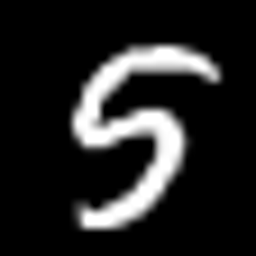

In [7]:
# get 2 data images in order to test predictions later on
csv_input = "0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,149,156,179,254,254,201,119,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,147,241,253,253,254,253,253,253,253,245,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,224,253,253,180,174,175,174,174,174,174,223,247,145,6,0,0,0,0,0,0,0,0,0,0,0,0,7,197,254,253,165,2,0,0,0,0,0,0,12,102,184,16,0,0,0,0,0,0,0,0,0,0,0,0,152,253,254,162,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235,254,158,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74,250,253,15,0,0,0,16,20,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,199,253,253,0,0,25,130,235,254,247,145,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,253,253,177,100,219,240,253,253,254,253,253,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,193,253,253,254,253,253,200,155,155,238,253,229,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,249,254,241,150,30,0,0,0,215,254,254,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,39,30,0,0,0,0,0,214,253,234,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,241,253,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201,253,253,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,254,253,154,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,254,255,241,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,118,235,253,249,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,81,0,102,211,253,253,253,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79,243,234,254,253,253,216,117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,245,253,254,207,126,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,220,179,6,0,0,0,0,0,0,0,0,9,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28,247,17,0,0,0,0,0,0,0,0,27,202,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,242,155,0,0,0,0,0,0,0,0,27,254,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,160,207,6,0,0,0,0,0,0,0,27,254,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127,254,21,0,0,0,0,0,0,0,20,239,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,254,21,0,0,0,0,0,0,0,0,195,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70,254,21,0,0,0,0,0,0,0,0,195,142,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,56,251,21,0,0,0,0,0,0,0,0,195,227,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,153,5,0,0,0,0,0,0,0,120,240,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,67,251,40,0,0,0,0,0,0,0,94,255,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,234,184,0,0,0,0,0,0,0,19,245,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,234,169,0,0,0,0,0,0,0,3,199,182,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,154,205,4,0,0,26,72,128,203,208,254,254,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,254,129,113,186,245,251,189,75,56,136,254,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,216,233,233,159,104,52,0,0,0,38,254,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,254,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,254,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,206,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,186,159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,209,101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"
elements = csv_input.split("\n")
json_input = str([list(map(int, e.split(","))) for e in elements])

five_img_data = "0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,149,156,179,254,254,201,119,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,147,241,253,253,254,253,253,253,253,245,160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,224,253,253,180,174,175,174,174,174,174,223,247,145,6,0,0,0,0,0,0,0,0,0,0,0,0,7,197,254,253,165,2,0,0,0,0,0,0,12,102,184,16,0,0,0,0,0,0,0,0,0,0,0,0,152,253,254,162,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,235,254,158,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74,250,253,15,0,0,0,16,20,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,199,253,253,0,0,25,130,235,254,247,145,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,253,253,177,100,219,240,253,253,254,253,253,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,193,253,253,254,253,253,200,155,155,238,253,229,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,249,254,241,150,30,0,0,0,215,254,254,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,39,30,0,0,0,0,0,214,253,234,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,241,253,183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,201,253,253,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,114,254,253,154,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,254,255,241,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,118,235,253,249,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55,81,0,102,211,253,253,253,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79,243,234,254,253,253,216,117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,245,253,254,207,126,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0"
five_arr = np.fromstring(five_img_data, sep=",")
print(five_arr.shape)
five_arr = five_arr.reshape((IMG_SIZE, IMG_SIZE))
print(five_arr.shape)
display(Image.fromarray(five_arr).convert("L").resize((256, 256)))
five_arr = np.expand_dims(five_arr, (0, -1))

(2, 28, 28, 1)


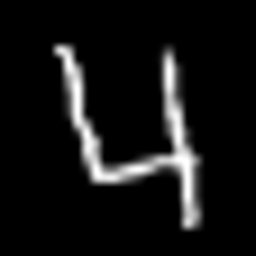

In [8]:
# ------------ Verify that the inference input handler actually work as expected ----------
### CSV INPUT ###
d = csv_input.split("\n")
for i, e in enumerate(d):
    array = np.fromstring(e, sep=",")
    array = array.reshape((1, IMG_SIZE, IMG_SIZE, 1))
    if i == 0:
        _input = array
    else:
        _input = np.concatenate([_input, array], axis=0)
print(_input.shape)
display(Image.fromarray(np.squeeze(_input[1])).convert("L").resize((256, 256)))

In [9]:
### JSON INPUT ###
tmp = json.loads(json_input)
for i, e in enumerate(tmp):
    array = np.asarray(e)
    array = array.reshape((1, IMG_SIZE, IMG_SIZE, 1))
    if i == 0:
        _input = array
    else:
        _input = np.concatenate([_input, array], axis=0)
print(_input.shape)

(2, 28, 28, 1)


## Train and test locally

In [10]:
# build the estimator
estimator = TensorFlow(entry_point=ENTRY_POINT_TRAIN,
                       source_dir="../source_dir",
                       output_path=MODEL_ARTIFACTS_S3_LOCATION,
                       code_location=CUSTOM_CODE_TRAIN_UPLOAD_S3_LOCATION,
                       base_job_name=BASE_JOB_NAME,
                       role=get_execution_role(),
                       framework_version=FRAMEWORK_VERSION,
                       hyperparameters=hyperparameters,
                       instance_count=1,
                       py_version=PYTHON_VERSION,
                       instance_type="local", #"ml.m4.xlarge",
                       distributions={'parameter_server': {'enabled': True}},
                       session=SESS,
                       enable_network_isolation=False)

In [11]:
estimator.fit({"train": TRAIN_DATA_S3_LOCATION, "test": TEST_DATA_S3_LOCATION})

Creating tmpcwpo8ped_algo-1-e1s31_1 ... 
Attaching to tmpcwpo8ped_algo-1-e1s31_12mdone
algo-1-e1s31_1  | 2020-11-03 17:36:31,470 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-e1s31_1  | 2020-11-03 17:36:31,477 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-e1s31_1  | 2020-11-03 17:36:32,681 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-e1s31_1  | 2020-11-03 17:36:32,699 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-e1s31_1  | 2020-11-03 17:36:32,717 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-e1s31_1  | 2020-11-03 17:36:32,729 sagemaker-containers INFO     Invoking user script
algo-1-e1s31_1  | 
algo-1-e1s31_1  | Training Env:
algo-1-e1s31_1  | 
algo-1-e1s31_1  | {
algo-1-e1s31_1  |     "additional_framework_parameters": {},
algo-1-e1s31_1  |     "channel_input_dirs": {
algo-1-e1s31_1  

In [12]:
# -------- LOCAL DEPLOY ---------
latest_training_job = estimator.latest_training_job.name
print(latest_training_job)

local_endpoint_name = f"endpoint-tf2-keras-mnist-local"
print(local_endpoint_name)

mnist-tf2-keras-model-training-job-2020-11-03-17-35-34-837
endpoint-tf2-keras-mnist-local


In [ ]:
local_predictor = estimator.deploy(endpoint_name=local_endpoint_name, initial_instance_count=1, instance_type='local')

In [ ]:
local_predictor.predict(five_arr)

## Deployment to a SageMaker Endpoint

In [20]:
# -------- SAGEMAKER DEPLOY ---------
latest_training_job = estimator.latest_training_job.name
print("Latest training job :", latest_training_job)

_id = ""
model_name = "model-tf2-keras-mnist-"+str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
endpoint_configuration_name = f"endpoint-configuration-tf2-keras-mnist-"+str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
endpoint_name = f"endpoint-tf2-keras-mnist-"+str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
print("Model name :", model_name)
print("Endpoint configuration name :", endpoint_configuration_name)
print("Endpoint name :", endpoint_name)

Latest training job : mnist-tf2-keras-model-training-job-2020-10-26-11-48-08-659
Model name : model-tf2-keras-mnist-2020-10-26-11-53-48
Endpoint configuration name : endpoint-configuration-tf2-keras-mnist-2020-10-26-11-53-48
Endpoint name : endpoint-tf2-keras-mnist-2020-10-26-11-53-48


In [21]:
# ----- sagemaker version <=1.17 ---------
#tf_model = sagemaker.tensorflow.serving.Model(
#    source_dir="../source_dir",
#    entry_point=ENTRY_POINT_INFERENCE,
#    framework_version=FRAMEWORK_VERSION,
#    model_data=f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/training/{latest_training_job}/model.tar.gz",
#    name=model_name,
#    role=get_execution_role())

# ----- sagemaker version >= 2.15.0 -------
tf_model = TensorFlowModel(
              entry_point=ENTRY_POINT_INFERENCE,
              source_dir='../source_dir',
              framework_version=FRAMEWORK_VERSION,
              model_data=f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/training/{latest_training_job}/model.tar.gz",
              code_location=CUSTOM_CODE_SERVING_UPLOAD_S3_LOCATION,
              name=model_name,
              role=get_execution_role(),
              sagemaker_session=SESS)

We are going to execute three steps to divide the easy way of deploy an endpoint.

Normally you can simply deploy your model to an endpoint thanks to :

In [22]:
predictor = tf_model.deploy(endpoint_name=endpoint_name, instance_type='ml.p2.xlarge', initial_instance_count=1)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------------!

Here we are going to do :
1. Create the model - container + code
2. Create an endpoint configuration for the model
3. Create an endpoint finally

In [85]:
create_model_def = tf_model.prepare_container_def(instance_type="ml.p2.xlarge")
print(create_model_def)

{'Image': '763104351884.dkr.ecr.eu-west-1.amazonaws.com/tensorflow-inference:2.1.0-gpu', 'Environment': {}, 'ModelDataUrl': 's3://sagemaker-eu-west-1-288840635390/mnist-tensorflow2-scriptmode/serving-model/model-tf2-keras-mnist-2020-10-13-16-47-06/model.tar.gz'}


In [90]:
sm_client = boto3.client('sagemaker')

In [86]:
# ------ SAGEMAKER MODEL CREATION ------
sagemaker_model = sm_client.create_model(
                      ModelName=model_name,
                      PrimaryContainer={
                          'Image': create_model_def["Image"],
                          'Mode': 'SingleModel',
                          'ModelDataUrl': create_model_def["ModelDataUrl"],
                          'Environment': create_model_def["Environment"]
                      },
                      ExecutionRoleArn=get_execution_role())
print(sagemaker_model)

{'ModelArn': 'arn:aws:sagemaker:eu-west-1:288840635390:model/model-tf2-keras-mnist-2020-10-13-16-47-06', 'ResponseMetadata': {'RequestId': '6e1392ac-dc58-4abc-8129-115984ad5e45', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '6e1392ac-dc58-4abc-8129-115984ad5e45', 'content-type': 'application/x-amz-json-1.1', 'content-length': '103', 'date': 'Tue, 13 Oct 2020 16:47:23 GMT'}, 'RetryAttempts': 0}}


In [47]:
# ------ SAGEMAKER ENDPOINT CONFIGURATION CREATION ------ 
endpoint_config = sm_client.create_endpoint_config(
                    EndpointConfigName=endpoint_configuration_name,
                    ProductionVariants=[
                        {
                            'VariantName': "model1",
                            'ModelName': model_name,
                            'InitialInstanceCount': 1,
                            'InstanceType': 'ml.t2.medium',
                            'InitialVariantWeight': 1
                        },
                        {
                            'VariantName': "model1",
                            'ModelName': model_name,
                            'InitialInstanceCount': 1,
                            'InstanceType': 'ml.t2.medium',
                            'InitialVariantWeight': 1
                        }
                    ],
                    DataCaptureConfig={
                        'EnableCapture': True,
                        'InitialSamplingPercentage': 100,
                        'DestinationS3Uri': f"s3://{DEFAULT_BUCKET}/{PROJECT_ID}/inference",
                        'CaptureOptions': [
                            {
                                'CaptureMode': 'Input'
                            },
                            {
                                'CaptureMode': 'Output'
                            }
                        ]
                    })
print(endpoint_config)

{'EndpointConfigArn': 'arn:aws:sagemaker:eu-west-1:288840635390:endpoint-config/endpoint-configuration-tf2-keras-mnist-2020-10-13-15-30-53', 'ResponseMetadata': {'RequestId': '31535d21-1af7-42dc-bb2a-7da492964373', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '31535d21-1af7-42dc-bb2a-7da492964373', 'content-type': 'application/x-amz-json-1.1', 'content-length': '139', 'date': 'Tue, 13 Oct 2020 15:45:53 GMT'}, 'RetryAttempts': 0}}


In [49]:
sagemaker_endpoint = sm_client.create_endpoint(
                        EndpointName=endpoint_name,
                        EndpointConfigName=endpoint_configuration_name)
print(sagemaker_endpoint)

{'EndpointArn': 'arn:aws:sagemaker:eu-west-1:288840635390:endpoint/endpoint-tf2-keras-mnist-2020-10-13-15-30-53', 'ResponseMetadata': {'RequestId': '64e62ee9-e97e-41f1-bdba-289e5dbb685b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '64e62ee9-e97e-41f1-bdba-289e5dbb685b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '112', 'date': 'Tue, 13 Oct 2020 15:48:07 GMT'}, 'RetryAttempts': 0}}


## Production Variant and A/B Testing

Before doing this you should before retrain another model and create a new Model entity based on this new model.

In [94]:
list_models = [model_info["ModelName"] for model_info in sm_client.list_models()["Models"]]
print(list_models)

['model-tf2-keras-mnist-2020-10-13-16-47-06', 'model-tf2-keras-mnist-2020-10-13-15-30-53']


In [93]:
assert(len(list_models) == 2)
multi_models_endpoint_config_name = f"ept-config-multi-tf2-keras-mnist-"+str(datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
multi_models_endpoint_config = sm_client.create_endpoint_config(
                                    EndpointConfigName=multi_models_endpoint_config_name,
                                    ProductionVariants=[
                                        {
                                            'VariantName': "model1",
                                            'ModelName': list_models[0],
                                            'InitialInstanceCount': 1,
                                            'InstanceType': 'ml.t2.medium',
                                            'InitialVariantWeight': 0.5
                                        },
                                        {
                                            'VariantName': "model2",
                                            'ModelName': list_models[1],
                                            'InitialInstanceCount': 1,
                                            'InstanceType': 'ml.t2.medium',
                                            'InitialVariantWeight': 0.5
                                        }
                                    ])
print(multi_models_endpoint_config)

{'EndpointConfigArn': 'arn:aws:sagemaker:eu-west-1:288840635390:endpoint-config/ept-config-multi-tf2-keras-mnist-2020-10-13-16-55-55', 'ResponseMetadata': {'RequestId': 'ce8ecef4-7d2d-4383-804f-e1f5d5a7b2e0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ce8ecef4-7d2d-4383-804f-e1f5d5a7b2e0', 'content-type': 'application/x-amz-json-1.1', 'content-length': '133', 'date': 'Tue, 13 Oct 2020 16:55:55 GMT'}, 'RetryAttempts': 0}}


## Get predictions

In [25]:
# prediction service
runtime = boto3.client('sagemaker-runtime')

### Using the invoke endpoint

This is useful when you only need to invoke the endpoint once.

In [26]:
# csv serialization
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=csv_input,
    ContentType='text/csv')

json.loads(response['Body'].read().decode("utf-8"))

{'predictions': [[4.09608674e-06,
   3.01769802e-07,
   4.25787732e-07,
   0.00042130964,
   1.21807134e-05,
   0.976147771,
   0.000165230507,
   1.15498744e-06,
   0.000163593912,
   0.0230839979],
  [0.00165798888,
   0.00751685444,
   0.00448381202,
   0.00165989914,
   0.943219125,
   0.00763144158,
   0.0267933253,
   0.00343788089,
   0.0010305742,
   0.00256915577]]}

In [110]:
# csv serialization
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=json_input,
    ContentType='application/json')

json.loads(response['Body'].read().decode("utf-8"))

{'predictions': [[3.96816213e-05,
   3.19169317e-07,
   3.04262016e-07,
   0.00028424745,
   2.87641251e-05,
   0.992996275,
   0.000425830105,
   1.05173922e-05,
   0.000281373184,
   0.00593271479],
  [0.00738942856,
   0.011011513,
   0.00777793443,
   0.000898721046,
   0.935718,
   0.00152082252,
   0.00536923716,
   0.0139825959,
   0.000997162424,
   0.015334676]]}

### Real Time Predictor

This can be useful if you wish to invoke the endpoint more than once.

In [ ]:
csv_rtp = TensorFlowPredictor(endpoint_name=endpoint_name, serializer=sagemaker.serializers.CSVSerializer())
csv_rtp.predict(csv_input)